In [ ]:
!pip install kaggle

In [ ]:
!ls

sample_data


In [6]:
# Install Kaggle API
!pip install kaggle

# Upload kaggle.json (do this manually in the Files tab)
# After uploading kaggle.json, run:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors


In [9]:
import pandas as pd
df = pd.read_csv('/sample_data/telco-customer-churn.csv')
print(df.head())  # View first 5 rows
print(df.info())  # Check data types and missing values

FileNotFoundError: [Errno 2] No such file or directory: '/sample_data/telco-customer-churn.csv'

In [10]:
!ls /content/

kaggle.json  sample_data  telco-customer-churn.zip


In [11]:
!unzip telco-customer-churn.zip

Archive:  telco-customer-churn.zip
  inflating: WA_Fn-UseC_-Telco-Customer-Churn.csv  


In [12]:
import pandas as pd
df = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(df.head())  # View first 5 rows
print(df.info())  # Check data types and missing values

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [14]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print(df['TotalCharges'].isnull().sum())  # Should print 0

0


In [15]:
# Identify categorical columns (exclude customerID and Churn)
categorical_cols = df.select_dtypes(include=['object']).columns.drop(['customerID', 'Churn'])
# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(df.head())  # Check new columns

   customerID  SeniorCitizen  tenure  MonthlyCharges  TotalCharges Churn  \
0  7590-VHVEG              0       1           29.85         29.85    No   
1  5575-GNVDE              0      34           56.95       1889.50    No   
2  3668-QPYBK              0       2           53.85        108.15   Yes   
3  7795-CFOCW              0      45           42.30       1840.75    No   
4  9237-HQITU              0       2           70.70        151.65   Yes   

   gender_Male  Partner_Yes  Dependents_Yes  PhoneService_Yes  ...  \
0        False         True           False             False  ...   
1         True        False           False              True  ...   
2         True        False           False              True  ...   
3         True        False           False             False  ...   
4        False        False           False              True  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False            False   
1           

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [17]:
df['Tenure_MonthlyCharges_Ratio'] = df['tenure'] / (df['MonthlyCharges'] + 1e-6)  # Avoid division by zero

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Define features and target
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
print(y_train_bal.value_counts())  # Should show balanced classes

Churn
0    4138
1    4138
Name: count, dtype: int64


In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_bal, y_train_bal)

RandomForestClassifier(random_state=42)

In [20]:
from sklearn.metrics import classification_report, roc_auc_score

# Make predictions
y_pred_rf = rf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred_rf))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print(f'AUC-ROC: {roc_auc:.2f}')

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1036
           1       0.57      0.64      0.61       373

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.73      1409
weighted avg       0.79      0.78      0.78      1409

AUC-ROC: 0.84


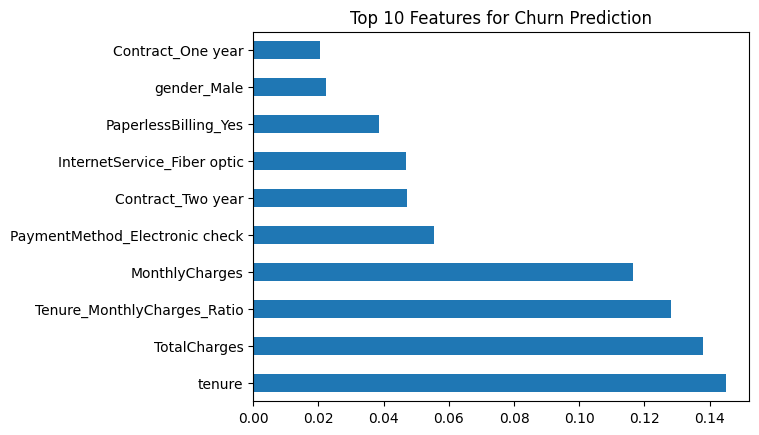

<Figure size 640x480 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_importance = pd.Series(rf.feature_importances_, index=X.columns)
feat_importance.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features for Churn Prediction')
plt.show()
plt.savefig('/content/feature_importance.png')

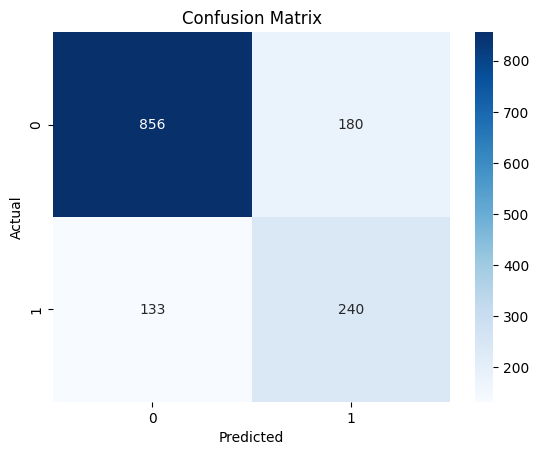

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred_rf are defined from your Random Forest model
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Save the plot for GitHub
plt.savefig('/content/confusion_matrix.png')
plt.close()  # Close the plot to free memory

In [24]:
y_pred_rf = rf.predict(X_test)